In [1]:
# core imports
import os, sys, json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# adds parent directory to python path so we can access the pre-trained models in keras_models director
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path: sys.path.append(nb_dir)

In [3]:
# ml imports
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))

from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

from pretrained_models.vgg19 import VGG19
from pretrained_models.vgg16 import VGG16
from pretrained_models.imagenet_utils import preprocess_input, decode_predictions

Using TensorFlow backend.


In [4]:
path = "data/"
# path = "data/sample/"

batch_size = 64

In [5]:
model = VGG19(weights='imagenet', include_top=True)

In [6]:
# model.summary()

In [7]:
gen = image.ImageDataGenerator()
train_batches = gen.flow_from_directory(path+'train', target_size=(224,224), 
                                        class_mode='categorical', shuffle=True, batch_size=batch_size)

gen = image.ImageDataGenerator()
val_batches = gen.flow_from_directory(path+'valid', target_size=(224,224), 
                                        class_mode='categorical', shuffle=True, batch_size=batch_size*2)

Found 22000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


In [8]:
# train_batches.class_indices
# train_batches.num_class

In [9]:
model.layers.pop()
for layer in model.layers: layer.trainable = False
    
# recover the output from the last layer in the model and use as input to new Dense layer
last = model.layers[-1].output
x = Dense(train_batches.num_class, activation="softmax")(last)
model = Model(model.input, x)

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# model.summary()

In [ ]:
train_steps = train_batches.n / batch_size
val_steps = val_batches.n / batch_size

model.fit_generator(train_batches, steps_per_epoch=train_steps, epochs=3, 
                    validation_data=val_batches, validation_steps=val_steps)

Epoch 1/3
344/343 [==============================] - 503s - loss: 0.1168 - acc: 0.9608 - val_loss: 0.1000 - val_acc: 0.9695
Epoch 2/3
344/343 [==============================] - 479s - loss: 0.0853 - acc: 0.9729 - val_loss: 0.1095 - val_acc: 0.9693
Epoch 3/3
343/343 [============================>.] - ETA: 0s - loss: 0.0619 - acc: 0.9780

In [12]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

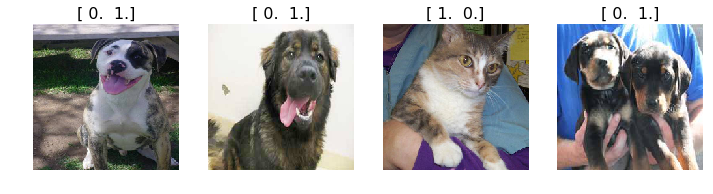

In [13]:
imgs, labels = next(train_batches)

plots(imgs, titles=labels)

In [14]:
preds = model.predict(imgs) # returns probabilities for each image ([ [.999, .01], [.825, .175] ])

In [16]:
idxs = np.argmax(preds, axis=1) # returns index of highest probability for each image ([0,1,0,1])

In [17]:
predicted_probs = [preds[i, idxs[i]] for i in range(len(idxs))] # returns probability of predicted label ([.99, 1.0])

In [18]:
# train_batches.class_indices => {'cats': 0, 'dogs': 1}
model_classes = list(iter(train_batches.class_indices)) # returns ['cats', 'dogs']
classes = [model_classes[idx] for idx in idxs] # returns ['cats', 'dogs', 'cats', 'dogs']

In [19]:
for i in range(len(idxs)):
    print('{0:.4f}/{1}'.format(predicted_probs[i], classes[i]))

1.0000/cats
1.0000/cats
1.0000/dogs
1.0000/cats
